# Playing MountainCar with the Actor-Critic method


Implementation of the [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) method using TensorFlow to train an agent on the [Open AI Gym](https://www.gymlibrary.dev/) [`MountainCar-v0`](https://gymnasium.farama.org/environments/classic_control/mountain_car/#mountain-car) environment.

Adaptation of the [notebook](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb?hl=fr) seen in class for the environnement `MountainCar-v0`.



**`MountainCar-v0`**

In the [`MountainCar-v0` environment](https://gymnasium.farama.org/environments/classic_control/mountain_car/#mountain-car), a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill.

<center>
  <figure>
    <image src="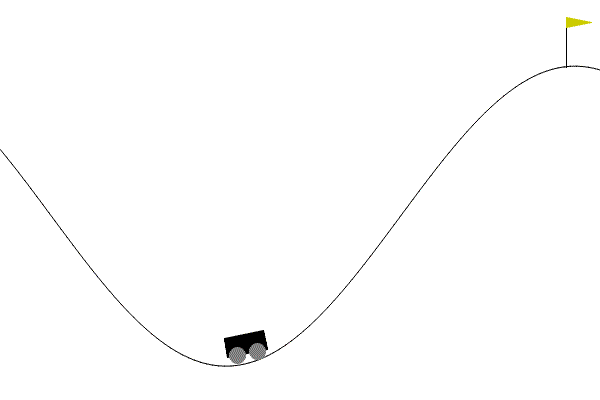">
    <figcaption>
      Trained actor-critic model in MountainCar-v0 environment
    </figcaption>
  </figure>
</center>


## Setup

Import necessary packages and configure global settings.


In [97]:
!pip install gymnasium[classic_control]
!pip install pyglet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [98]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y python-opengl > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [99]:
# import packages
import collections
import gymnasium as gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple

In [100]:
# packages versions
import pkg_resources

packages = ['numpy', 'tensorflow', 'matplotlib', 'gymnasium', 'tqdm']

for package in packages:
    try:
        version = pkg_resources.get_distribution(package).version
        print(f"{package} version: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"{package} n'est pas installé.")

# numpy version: 1.22.4
# tensorflow version: 2.12.0
# matplotlib version: 3.7.1
# gymnasium version: 0.28.1
# tqdm version: 4.65.0

numpy version: 1.22.4
tensorflow version: 2.12.0
matplotlib version: 3.7.1
gymnasium version: 0.28.1
tqdm version: 4.65.0


In [101]:
# environment
env = gym.make("MountainCar-v0")

# seed
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [102]:
print("Observation space : ", env.observation_space,
      "\nAction space : ", env.action_space)

Observation space :  Box([-1.2  -0.07], [0.6  0.07], (2,), float32) 
Action space :  Discrete(3)


## The model

The *Actor* and *Critic* will be modeled using one neural network that generates the action probabilities and Critic value respectively. We use model subclassing to define the model. 

For `MountainCar-v0`, there are two values representing the state : 	
* position of the car along the x-axis 
* velocity of the car. 

The agent can take three actions :
* accelerate to the left (`0`)
* don't accelerate (`1`) 
* accelerate to the right (`2`)



In [103]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [104]:
num_actions = env.action_space.n  # 3
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

## Train the agent

### 1. Collect training data


In [105]:
# Wrap Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, truncated, info = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

We're changing the reward system because otherwise the agent never gets a positive reward and therefore never learn until he reaches the flag for the first. 

Relying on randomness to reach the flag the first time could cost a lot of iterations...

Thus, we replace the reward by the square velocity $\nu^{2}$ of the car (given in the variable state at each step), making the assumption that if the car is going fast it should be able to reach the flag, so the agent must try to gain speed. 

We're adding a bonus reward if the car reaches the flag, so that the agent learns to drive towards the flag (on the left) and not just up the hill.

In [106]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (to be compatible with the model)
    state = tf.expand_dims(state, 0)
  
    # Run the model to get action probabilities and critic value
    action_logits_t, value = model(state)
  
    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])
  
    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)

    # Modify reward system
    reward = (state[1]**2)
    if tf.cast(done, tf.bool):
      reward += 10 # bonus if the flag is reached
    
    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()
  
  return action_probs, values, rewards

### 2. Expected returns

The sequence of rewards for each timestep $t$ collected during one episode is converted into a sequence of expected returns in which the sum of rewards is taken from the current timestep $t$ to $T$ and each reward is multiplied with an exponentially decaying discount factor $\gamma$



In [107]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize: # to stabilize training
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

### 3. Actor-Critic loss

Since we are using hybrid Actor-Critic model, the chosen loss function is a combination of Actor and Critic losses for training. 


In [108]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined Actor-Critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

### 4. Training step to update parameters

All of the steps above are combined into a training step that is run every episode. All steps leading up to the loss function are executed with the `tf.GradientTape` context to enable automatic differentiation.

We use the Adam optimizer to apply the gradients to the model parameters.

The sum of the undiscounted rewards, `episode_reward`, is also computed in this step. This value will be used later on to evaluate if the success criterion is met.

The `tf.function` context is applied to the `train_step` function so that it can be compiled into a callable TensorFlow graph, which can lead to 10x speedup in training.


In [109]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode) 

    # Calculate the expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculate the loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

### 5. Training loop

Training is executed by running the training step until either the success criterion or maximum number of episodes is reached.  

In [110]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 200 # MoutainCar is truncated at 200 steps

# The discount factor for future rewards
gamma = 0.99

# According to our reward system, MountainCar is considered to be solved if reward >= 10
reward_treshold = 10
running_reward = 0

all_episodes_reward = []

# Keep the last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

t = tqdm.trange(max_episodes)
for i in t:
     # Reset environnement at each episode
    initial_state, info = env.reset() 
    initial_state = tf.constant(initial_state, dtype=tf.float32)
    # Train step to update parameters
    episode_reward = train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode)
    
    all_episodes_reward.append(episode_reward)

    # Store last episode reward (and drop first reward of the list if len > 100)
    episodes_reward.append(episode_reward)

    # Compute mean of last 100 episode rewards
    running_reward = np.mean(episodes_reward)

    # Display current episode_reward and running_reward with tqdm
    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)
    
    # Exit the loop if success criteria is satisfied
    if running_reward >= reward_treshold and i > min_episodes_criterion:
      break
  

100%|██████████| 10000/10000 [20:39<00:00,  8.07it/s, episode_reward=tf.Tensor(10.132502, shape=(), dtype=float32), running_reward=8.52]

CPU times: user 27min 7s, sys: 43.9 s, total: 27min 51s
Wall time: 20min 39s


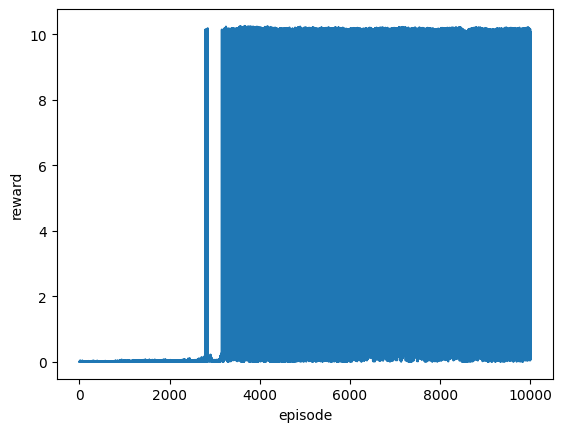

In [113]:
# Plot all episode reward
plt.plot(range(max_episodes), all_episodes_reward)
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()

The agent starts to reach the flag frequently after around 3000 iterations,  but the algorithm does not converge after 10000 iterations.  

The reward system is surely not optimal.

## Visualization


In [118]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make("MountainCar-v0", render_mode='rgb_array')

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  state, info = env.reset()
  state = tf.constant(state, dtype=tf.float32)
  screen = env.render()
  images = [Image.fromarray(screen)]
 
  # Run episode
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, reward, done, truncated, info = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render()
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(render_env, model, max_steps_per_episode)
image_file = 'MountainCar-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


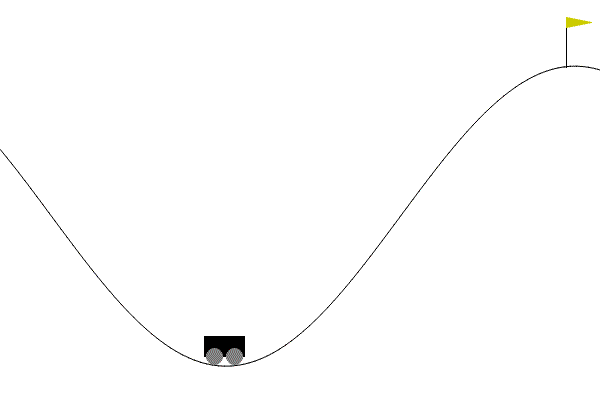

In [119]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)